<a href="https://colab.research.google.com/github/Rogerio-mack/work/blob/main/KaplanMeier_COX_BreastCancer_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modelo Cox e Kaplan-Meier de Sobrevivência**

Um exemplo. Trata-se apenas de um exemplo e não faço aqui nenhum refinamento dos modelos... mas o esquema de utilização para tempo de vida de peças, dispositivos etc. pode ser o mesmo.

# **Imports**

In [1]:
!pip install scikit-survival --quiet # não empregado aqui
!pip install lifelines --quiet
!pip install seaborn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.2/349.2 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 4.7 MB/s eta 0:00:00


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sksurv.datasets import load_breast_cancer
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

from sklearn import set_config
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

set_config(display="text")

# **Carrega base exemplo de dados de pacientes com Câncer**

In [26]:
X, y = load_breast_cancer()
X, y

(     X200726_at  X200965_s_at  X201068_s_at  X201091_s_at  X201288_at  \
 0     10.926361      8.962608     11.630078     10.964107   11.518305   
 1     12.242090      9.531718     12.626106     11.594716   12.317659   
 2     11.661716     10.238680     12.572919      9.166088   11.698658   
 3     12.174021      9.819279     12.109888      9.086937   13.132617   
 4     11.484011     11.489233     11.779285      8.887616   10.429663   
 ..          ...           ...           ...           ...         ...   
 193   12.018292      8.323876     11.955274     10.740020   11.150428   
 194   11.711415     10.428482     12.420877     11.145993   11.084685   
 195   11.939616      9.615587     11.962812     10.463171   11.514539   
 196   11.848449     10.528911     11.318453      8.609631   13.719035   
 197   11.425778      9.901486     12.167550      9.011730   12.013692   
 
      X201368_at  X201663_s_at  X201664_at  X202239_at  X202240_at  ...  \
 0     12.038527      9.623518    9

# **Tratamento dos Dados**

In [27]:
X, y = load_breast_cancer()
Xt = OneHotEncoder().fit_transform(X)

In [28]:
Xt['days'] = [tup[-1] for tup in y] # contém o tempo de sobrevivência (dias)
Xt['event'] = [tup[0] for tup in y] # indica se o evento (morte) ocorreu (1 para sim, 0 para não)
Xt['event'] = [not x for x in Xt['event']]

In [29]:
Xt.head()

,X200726_at,X200965_s_at,X201068_s_at,X201091_s_at,X201288_at,X201368_at,X201663_s_at,X201664_at,X202239_at,X202240_at,...,X221916_at,X221928_at,age,er=positive,grade=intermediate,grade=poorly differentiated,grade=unkown,size,days,event
0,10.926361,8.962608,11.630078,10.964107,11.518305,12.038527,9.623518,9.814798,10.016732,7.847383,...,6.477749,5.991885,57.0,0.0,0.0,1.0,0.0,3.0,723.0,False
1,12.242090,9.531718,12.626106,11.594716,12.317659,10.776911,10.604577,10.704329,10.161838,8.744875,...,4.968050,7.051130,57.0,1.0,0.0,1.0,0.0,3.0,6591.0,True
2,11.661716,10.238680,12.572919,9.166088,11.698658,11.353333,9.384927,10.161654,10.032721,8.125487,...,4.283777,6.828986,48.0,0.0,0.0,1.0,0.0,2.5,524.0,False
3,12.174021,9.819279,12.109888,9.086937,13.132617,11.859394,8.400839,8.670721,10.727427,8.650810,...,5.713404,6.927251,42.0,1.0,0.0,1.0,0.0,1.8,6255.0,True
4,11.484011,11.489233,11.779285,8.887616,10.429663,11.401139,7.741092,8.642018,9.556686,8.478862,...,5.817265,6.655448,46.0,1.0,1.0,0.0,0.0,3.0,3822.0,False


# **Kaplan-Meier**

Gera curva de sobrevivência empregando somente os dados de tempo e evento.


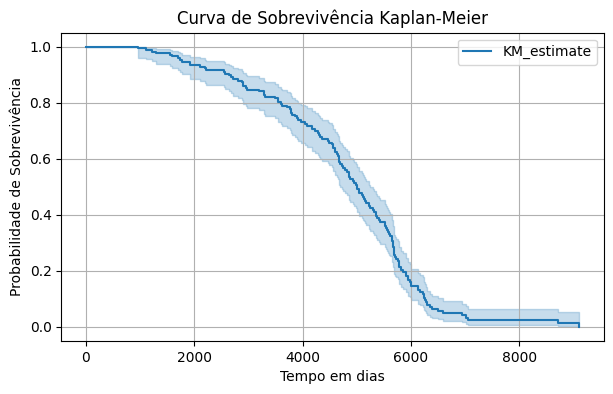

In [30]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
kmf.fit(Xt['days'], Xt['event'])


plt.figure(figsize=(7,4))
kmf.plot_survival_function()
plt.title('Curva de Sobrevivência Kaplan-Meier')
plt.xlabel('Tempo em dias')
plt.ylabel('Probabilidade de Sobrevivência')
plt.grid(True)
plt.show()

# **Regressão de Cox**

O próximo passo, depois das curvas de sobrevivência pode ser criar um modelo de regressão que inclui outras variáveis. Esse modelo, além do poder explicativo (qual o poder de influência de cada preditor), pode ser empregado para predições.

In [31]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(Xt, duration_col='days', event_col='event')


cph.print_summary()

<lifelines.CoxPHFitter: fitted with 198 total observations, 51 right-censored observations>
             duration col = 'days'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 198
number of events observed = 147
   partial log-likelihood = -532.66
         time fit was run = 2024-06-03 20:05:36 UTC

---
                              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                           
X200726_at                   -0.40       0.67       0.57            -1.51             0.72                 0.22                 2.05
X200965_s_at                  0.14       1.15       0.24            -0.34             0.61                 0.71                 1.84
X201068_s_at                  0.92       2.51       0.56            -0.17             2.01                 0.84                 7.48
X201091_s_at                 -0.45       0.64       0.41            -1.26             0.36                 0.28                 1.43
X201288_at                    0.36       1.43       0.34            -0.31             1.03                 0.73                 2.79
X201368_at                   -0.33       0.72       0.34            -0.99             0.33                 0.37                 1.40
X201663_s_at                 -0.76       0.47       0.48            -1.70             0.18                 0.18                 1.19
X201664_at                    1.22       3.38       0.51             0.22             2.22                 1.24                 9.18
X202239_at                   -0.20       0.82       0.32            -0.83             0.44                 0.44                 1.55
X202240_at                   -0.03       0.97       0.23            -0.47             0.41                 0.63                 1.51
X202418_at                    0.34       1.41       0.55            -0.73             1.42                 0.48                 4.12
X202687_s_at                 -0.12       0.88       0.23            -0.57             0.32                 0.57                 1.38
X203306_s_at                  1.05       2.85       0.40             0.27             1.83                 1.31                 6.21
X203391_at                    1.02       2.78       0.32             0.39             1.65                 1.48                 5.22
X204014_at                   -0.29       0.75       0.23            -0.74             0.17                 0.48                 1.18
X204015_s_at                  0.19       1.21       0.30            -0.39             0.78                 0.68                 2.17
X204073_s_at                 -0.26       0.77       0.15            -0.54             0.03                 0.58                 1.03
X204218_at                   -0.42       0.66       0.36            -1.13             0.29                 0.32                 1.34
X204540_at                   -0.23       0.80       0.09            -0.41            -0.04                 0.66                 0.96
X204631_at                    0.24       1.28       0.14            -0.04             0.52                 0.96                 1.69
X204740_at                    0.20       1.22       0.26            -0.32             0.71                 0.73                 2.04
X204768_s_at                 -0.08       0.92       0.37            -0.80             0.64                 0.45                 1.90
X204888_s_at                  0.15       1.16       0.17            -0.19             0.48                 0.83                 1.62
X205034_at                   -0.62       0.54       0.22            -1.06            -0.18                 0.35                 0.84
X205848_at                    0.14       1.16       0.09            -0.03             0.32                 0.97                 1.38
X206295_at                   -0.09       0.91       0

# **C-index**

In [32]:
# Calcula o índice de concordância (concordance index) do modelo ajustado
concordance_index = cph.score(Xt, scoring_method='concordance_index')
print(f'Concordance Index: {concordance_index}')

Concordance Index: 0.7637101649537956


# **Survival Prediction**

In [37]:
y_pred = cph.predict_survival_function(Xt)
print("Previsões de tempo")
display(y_pred.head().index)

Previsões de tempo


Index([125.0, 269.0, 289.0, 394.0, 404.0], dtype='float64')

In [39]:
y_surv = [tup[-1] for tup in y]
print(len(y_surv), len(y_pred.index))

y_surv = y_surv[:len(y_pred.index)]
print(len(y_surv), len(y_pred.index))

df_s = pd.DataFrame({'Tempo em dias (Real)': y_surv, 'Tempo em dias (Previsto)': y_pred.index})
display(df_s.head())

198 195
195 195


,Tempo em dias (Real),Tempo em dias (Previsto)
0,723.0,125.0
1,6591.0,269.0
2,524.0,289.0
3,6255.0,394.0
4,3822.0,404.0


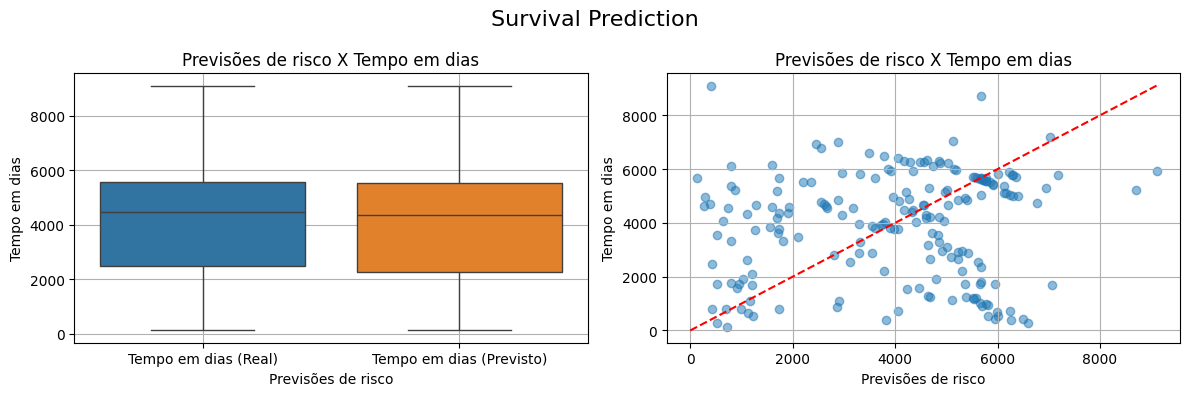

In [41]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.boxplot(df_s)
plt.xlabel('Previsões de risco')
plt.ylabel('Tempo em dias')
plt.title('Previsões de risco X Tempo em dias')
plt.grid(True)

plt.subplot(1,2,2)
plt.scatter(df_s['Tempo em dias (Real)'], df_s['Tempo em dias (Previsto)'], alpha=0.5)
plt.xlabel('Previsões de risco')
plt.ylabel('Tempo em dias')
plt.title('Previsões de risco X Tempo em dias')
plt.plot(np.linspace(0, df_s['Tempo em dias (Real)'].max(), 1000), np.linspace(0,  df_s['Tempo em dias (Real)'].max(), 1000), color='red', linestyle='--')
plt.grid(True)

plt.suptitle('Survival Prediction',fontsize=16)
plt.tight_layout()
plt.show()

In [42]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

mean_absolute_percentage_error(df_s['Tempo em dias (Real)'], df_s['Tempo em dias (Previsto)']), mean_squared_error(df_s['Tempo em dias (Real)'], df_s['Tempo em dias (Previsto)'])

(1.2897468304572661, 6903076.235897436)